In [87]:
from dataclasses import dataclass
from functools import partial
from math import floor 
from typing import Callable, Tuple, Any

import jax
from jax import debug
import jax.numpy as jnp
import flax.linen as nn
import optax
from chex import ArrayTree
from qdax.core.containers.repertoire import Repertoire
from qdax.types import Descriptor, ExtraScores, Fitness, Genotype, RNGKey
from qdax.environments.base_wrappers import QDEnv
from qdax.core.neuroevolution.buffers.buffer import QDTransition
from qdax.core.neuroevolution.buffers.trajectory_buffer import TrajectoryBuffer
from rein_related import *
from qdax import environments_v1, environments

from qdax.core.emitters.emitter import Emitter, EmitterState

In [88]:
def get_env(env_name):
    if env_name == "hopper_uni":
        episode_length = 1000
        
        env = environments_v1.create(env_name, episode_length=episode_length)
    elif env_name == "halfcheetah_uni":
        episode_length = 1000

        env = environments_v1.create(env_name, episode_length=episode_length)
        
    elif env_name == "walker2d_uni":
        episode_length = 1000

        env = environments_v1.create(env_name, episode_length=episode_length)	
    elif env_name == "ant_uni":
        episode_length = 1000

        env = environments_v1.create(env_name, episode_length=episode_length, use_contact_forces=False, exclude_current_positions_from_observation=True)
    elif env_name == "humanoid_uni":
        episode_length = 1000

        env = environments_v1.create(env_name, episode_length=episode_length, exclude_current_positions_from_observation=True)	
    '''
    elif env_name == "ant_omni":
        episode_length = 250
        max_bd = 30.

        env = environments.create(env_name, episode_length=episode_length, use_contact_forces=False, exclude_current_positions_from_observation=False)	
    elif env_name == "humanoid_uni":
        episode_length = 1000
        max_bd = 1.

        env = environments.create(env_name, episode_length=episode_length)	
    else:
        ValueError(f"Environment {env_name} not supported.")
    '''
    return env

In [89]:
@dataclass
class Config:
    """Configuration from this experiment script
    """
    # Env config
    #alg_name: str
    seed: int
    env_name: str
    episode_length: int
    policy_hidden_layer_sizes: Tuple[int, ...]   
    # ME config
    num_evaluations: int
    num_iterations: int
    batch_size: int
    num_samples: int
    fixed_init_state: bool
    discard_dead: bool
    # Emitter config
    iso_sigma: float
    line_sigma: float
    #crossover_percentage: float
    # Grid config 
    grid_shape: Tuple[int, ...]
    num_init_cvt_samples: int
    num_centroids: int
    # Log config
    log_period: int
    store_repertoire: bool
    store_repertoire_log_period: int
    
    # REINFORCE Parameters
    proportion_mutation_ga : float
    rollout_number: int
    num_rein_training_steps: int
    adam_optimizer: bool
    learning_rate: float
    discount_rate: float
    temperature: int
    buffer_size: int

In [90]:
config = Config(
    seed=0,
    env_name='ant_uni',
    episode_length=1000,
    policy_hidden_layer_sizes=[128, 128],
    num_evaluations=0,
    num_iterations=200,
    num_samples=32,
    batch_size=64,
    fixed_init_state=False,
    discard_dead=False,
    grid_shape=[50, 50],
    num_init_cvt_samples=50000,
    num_centroids=1296,
    log_period=400,
    store_repertoire=True,
    store_repertoire_log_period=800,
    iso_sigma=0.005,
    line_sigma=0.05,
    proportion_mutation_ga=0.5,
    rollout_number=32, # Num of episodes used for gradient estimate
    num_rein_training_steps=5, # Num gradient steps per generation
    buffer_size=102400, # Size of the replay buffer
    adam_optimizer=True,
    learning_rate=1e-3,
    discount_rate=0.99,
    temperature=0,
)

In [91]:
@dataclass
class REINaiveConfig:
    """Configuration for the REINaive emitter.
    
    Args:
        rollout_number: num of rollouts for gradient estimate
        sample_sigma: std to sample the samples for gradient estimate  (IS THIS PARAMETER SPACE EXPLORATION?)
        sample_mirror: if True, use mirroring sampling
        sample_rank_norm: if True, use normalisation
        
        num_generations_sample: frequency of archive-sampling
        
        adam_optimizer: if True, use ADAM, if False, use SGD
        learning_rate: obvious
        l2_coefficient: coefficient for regularisation
        
        novelty_nearest_neighbors: num of nearest neigbors for novelty computation
        use_novelty_archive: if True, use novelty archive for novelty (default is to use the content of the reperoire)
        use_novelty_fifo: if True, use fifo archive for novelty (default is to use the content of the repertoire)
        fifo_size: size of the novelty fifo bugger if used
        
        proprtion_explore: proportion of explore
    """
    batch_size: int = 32
    num_rein_training_steps: int = 10
    buffer_size: int = 320000
    rollout_number: int = 100
    discount_rate: float = 0.99
    adam_optimizer: bool = True
    learning_rate: float = 1e-3
    temperature: float = 0.



class REINaiveEmitterState(EmitterState):
    """Contains replay buffer.
    """
    trajectory_buffer: TrajectoryBuffer
    random_key: RNGKey
    
    
class REINaiveEmitter(Emitter):
    """
    An emitter that uses gradients approximated through rollouts.
    It dedicates part of the process on REINFORCE for fitness gradients and part
    to exploration gradients.
    
    This scan version scans through parents isntead of performing all REINFORCE
    operations in parallel, to avoid memory overload issue.
    """
    
    def __init__(
        self,
        config: REINaiveConfig,
        policy_network: nn.Module,
        env: QDEnv,
    ) -> None:
        self._config = config
        self._policy = policy_network
        self._env = env
            
            
        # SET UP THE LOSSES
        
        # Init optimizers
        
        self._policies_optimizer = optax.adam(
            learning_rate=self._config.learning_rate
            )
        
    @property
    def batch_size(self) -> int:
        """
        Returns:
            int: the batch size emitted by the emitter.
        """
        return self._config.batch_size
    
    @property 
    def use_all_data(self) -> bool:
        """Whether to use all data or not when used along other emitters.
        """
        return True
    
    @partial(jax.jit, static_argnames=("self",))
    def init(
        self,
        random_key: RNGKey,
        repertoire: Repertoire,
        genotypes: Genotype,
        fitnesses: Fitness,
        descriptors: Descriptor,
        extra_scores: ExtraScores,
    ) -> Tuple[REINaiveEmitterState, RNGKey]:
        """Initializes the emitter.

        Args:
            init_genotypes: The initial population.
            random_key: A random key.

        Returns:
            The initial state of the REINaiveEmitter, a new random key.
        """

        observation_size = self._env.observation_size
        action_size = self._env.action_size
        descriptor_size = self._env.state_descriptor_length
        
        # Init trajectory buffer
        dummy_transition = QDTransition.init_dummy(
            observation_dim=observation_size,
            action_dim=action_size,
            descriptor_dim=descriptor_size,
        )
        
        trajectory_buffer = TrajectoryBuffer.init(
            buffer_size=self._config.buffer_size,
            transition=dummy_transition,
            env_batch_size=self._config.batch_size,
            episode_length=self._env.episode_length,
        )
        
        random_key, subkey = jax.random.split(random_key)
        emitter_state = REINaiveEmitterState(
            trajectory_buffer=trajectory_buffer,
            random_key=subkey,
        )
        
        return emitter_state, random_key
    
    @partial(jax.jit, static_argnames=("self",))
    def emit(
        self,
        repertoire: Repertoire,
        emitter_state: REINaiveEmitterState,
        random_key: RNGKey,
    ) -> Tuple[Genotype, RNGKey]:
        """Do a step of REINFORCE emission.

        Args:
            repertoire: the current repertoire of genotypes.
            emitter_state: the state of the emitter used
            random_key: random key

        Returns:
            A batch of offspring, the new emitter state and a new key.
        """
        
        batch_size = self._config.batch_size
        
        # sample parents
        parents, random_key = repertoire.sample(random_key, batch_size)
        
        offsprings_rein = self.emit_rein(emitter_state, parents)
        
        genotypes = offsprings_rein
        
        return genotypes, {}, random_key
    
    @partial(jax.jit, static_argnames=("self",))
    def emit_rein(
        self,
        emitter_state: REINaiveEmitterState,
        parents: Genotype,
    ) -> Genotype:
        """Emit the offsprings generated through REINFORCE mutation.

        Args:
            emitter_state: the state of the emitter used, contains
            the trahectory buffer.
            parents: the parents selected to be applied gradients 
            to mutate towards better performance.

        Returns:
            A new set of offspring.
        """
        
        # Do a step of REINFORCE emission
        mutation_fn = partial(
            self._mutation_function_rein,
            emitter_state=emitter_state,
        )
        offsprings = jax.vmap(mutation_fn)(parents)
        
        return offsprings
    
    @partial(jax.jit, static_argnames=("self",))
    def _mutation_function_rein(
        self,
        policy_params: Genotype,
        emitter_state: REINaiveEmitterState,
    ) -> Genotype:
        """Apply REINFORCE mutation to a policy via multiple steps of gradient descent.

        Args:
            policy_params: a policy, supposed to be a differentiable neuaral network.
            emitter_state: the current state of the emitter, containing among others,
            the trajectory buffer.

        Returns:
            The updated parameters of the neural network.
        """
        
        # Define new policy optimizer state
        policy_optimizer_state = self._policies_optimizer.init(policy_params)
        
        def scan_train_policy(
            carry: Tuple[REINaiveEmitterState, Genotype, optax.OptState],
            unused: Any,
        ) -> Tuple[Tuple[REINaiveEmitterState, Genotype, optax.OptState], Any]:
            """Scans through the parents and applies REINFORCE training.
            """
            
            emitter_state, policy_params, policy_optimizer_state = carry
            
            (
                new_emitter_state,
                new_policy_params,
                new_policy_optimizer_state,
            ) = self._train_policy_(
                emitter_state,
                policy_params,
                policy_optimizer_state,
            )
            return (
                new_emitter_state,
                new_policy_params,
                new_policy_optimizer_state,
            ), ()
            
        (emitter_state, policy_params, policy_optimizer_state,), _ = jax.lax.scan(
            scan_train_policy,
            (emitter_state, policy_params, policy_optimizer_state),
            (),
            length=self._config.num_rein_training_steps,
        )
        
        return policy_params
        
    @partial(jax.jit, static_argnames=("self",))
    def _train_policy_(
        self,
        emitter_state: REINaiveEmitterState,
        policy_params: Genotype,
        policy_optimizer_state: optax.OptState,
    ) -> Tuple[REINaiveEmitterState, Genotype, optax.OptState]:
        """Apply one gradient step to a policy (called policy_params).

        Args:
            emitter_state: the current state of the emitter.
            policy_params: the current parameters of the policy network.
            policy_optimizer_state: the current state of the optimizer.

        Returns:
            The updated state of the emitter, the updated policy parameters
            and the updated optimizer state.
        """

        random_keys = jax.random.split(emitter_state.random_key, self._config.rollout_number+1)
        obs, action, logp, reward, _, mask = jax.vmap(
            self._sample_trajectory, in_axes=(0, None))(random_keys[:-1], policy_params)
        
        #debug.print("obs.shape: {}", obs.shape)
        
        # Add entropy term to reward
        reward += self._config.temperature * (-logp)
        
        # Compute standardized return
        return_standardized = self.get_return_standardized(reward, mask)
        
        # update policy
        policy_optimizer_state, policy_params = self._update_policy(
            policy_params=policy_params,
            policy_optimizer_state=policy_optimizer_state,
            obs=obs,
            action=action,
            logp=logp,
            mask=mask,
            return_standardized=return_standardized,
        )
        
        new_emitter_state = emitter_state.replace(
            random_key=random_keys[-1]
        )
        #print(reward * mask)
        #print('-'*50)
        
        #average_reward = jnp.mean(jnp.sum(reward * mask, axis=-1))
        #av_mask = jnp.mean(jnp.sum(mask, axis=-1))
        #debug.print("Average Reward: {}", average_reward)
        #debug.print('-'*50)      
        #debug.print("Average mask: {}", av_mask)  
        return new_emitter_state, policy_params, policy_optimizer_state
    
    @partial(jax.jit, static_argnames=("self",))
    def _sample_trajectory(
        self,
        random_key: RNGKey,
        policy_params: Genotype,
    ):
        """Samples a full trajectory using the environment and policy.
        Args:
            random_key: a random key.
            policy_params: the current parameters of the policy network.
        Returns:
            A tuple of observation, action, log-probability, reward, state descriptor, and mask arrays.
        """
        random_keys = jax.random.split(random_key, self._env.episode_length + 1)
        env_state_init = self._env.reset(random_keys[-1])
        #debug.print("env_state_init: {}", env_state_init)
        #debug.print('-'*50)        
        
        def _scan_sample_step(carry, x):
            (policy_params, env_state,) = carry
            (random_key,) = x
            
            next_env_state, action, action_logp = self.sample_step(
                random_key, policy_params, env_state
            )
            return (policy_params, next_env_state), (
                env_state.obs,
                action,
                action_logp,
                next_env_state.reward,
                env_state.done,
                env_state.info["state_descriptor"],
            )
        print(f"Length : {self._env.episode_length}")
        _, (obs, action, action_logp, reward, done, state_desc) = jax.lax.scan(
            _scan_sample_step,
            (policy_params, env_state_init),
            (random_keys[:self._env.episode_length],),
            length=self._env.episode_length,
        )
        
        # compute a mask to indicate the valid steps
        mask = 1. - jnp.clip(jnp.cumsum(done), a_min=0., a_max=1.)        
        return obs, action, action_logp, reward, state_desc, mask
    
    @partial(jax.jit, static_argnames=("self",))
    def sample_step(
        self,
        random_key: RNGKey,
        policy_params: Genotype,
        env_state: Any,
    ) -> Tuple[Any, Any, Any]:
        """Samples a step using the environment and policy.

        Args:
            random_key: a random key.
            policy_params: the current parameters of the policy network.
            env_state: the current state of the environment.

        Returns:
            A tuple of the next environment state, the action, and log-probability of the action.
        """
        #print(f"policy_params type: {type(policy_params)}")
        #print(f"policy_params: {policy_params}")
        #print(f"env_state.obs: {env_state.obs}")
        #print(f"env_state.obs type: {type(env_state.obs)}")
        '''
        action, action_logp = self._policy.sample(
            policy_params, random_key, env_state.obs
        )
        '''
        action, action_logp = self._policy.apply(
            policy_params, random_key, env_state.obs, method=self._policy.sample
        )

        next_env_state = self._env.step(env_state, action)
        
        return next_env_state, action, action_logp
    
    @partial(jax.jit, static_argnames=("self",))
    def get_return_standardized(self, reward: jnp.ndarray, mask: jnp.ndarray) -> jnp.ndarray:
        """Compute the standardized return.

        Args:
            reward: the reward obtained.
            mask: the mask to indicate the valid steps.

        Returns:
            The standardized return.
        """
        # compute the return
        return_ = jax.vmap(self.get_return)(reward * mask)
        return self.standardize(return_)
    
    @partial(jax.jit, static_argnames=("self",))
    def get_return(self, reward):
        """Computes the discounted return for each step in the trajectory.
        Args:
            reward: the reward array.
        Returns:
            The discounted return array.
        """
        def _body(carry, x):
            (next_return,) = carry
            (reward,) = x
            current_return = reward + self._config.discount_rate * next_return
            return (current_return,), (current_return,)
        
        _, (return_,) = jax.lax.scan(
            _body,
            (jnp.array(0.),),
            (reward,),
            length=self._env.episode_length,
            reverse=True,
        )
        return return_
    
    @partial(jax.jit, static_argnames=("self",))
    def standardize(self, return_):
        """Standardizes the return values.
        Args:
            return_: the return array.
        Returns:
            The standardized return array.
        """
        #return (return_ - return_.mean()) / (return_.std() + 1e-8)
        return jax.nn.standardize(return_, axis=0, variance=1., epsilon=EPS)

    @partial(jax.jit, static_argnames=("self",))
    def _update_policy(
        self,
        policy_params: Genotype,
        policy_optimizer_state: optax.OptState,
        obs,
        action,
        logp,
        mask,
        return_standardized
    ):
        """Updates the policy parameters using the optimizer.
        Args:
            policy_params: the current parameters of the policy network.
            policy_optimizer_state: the current state of the optimizer.
            obs: observations from the environment.
            action: actions taken in the environment.
            logp: log-probabilities of the actions.
            mask: the mask array indicating valid steps.
            return_standardized: the standardized return values.
        Returns:
            The updated optimizer state and policy parameters.
        """
        def loss_fn(params):
            #logp_ = self._policy.logp(params, jax.lax.stop_gradient(obs), jax.lax.stop_gradient(action))
            logp_ = self._policy.apply(params, jax.lax.stop_gradient(obs), jax.lax.stop_gradient(action), method=self._policy.logp)
            #return -jnp.mean(logp_ * mask * return_standardized)
            return -jnp.mean(jnp.multiply(logp_ * mask, jax.lax.stop_gradient(return_standardized)))

        grads = jax.grad(loss_fn)(policy_params)
        updates, new_optimizer_state = self._policies_optimizer.update(grads, policy_optimizer_state)
        new_policy_params = optax.apply_updates(policy_params, updates)
        return new_optimizer_state, new_policy_params

    @partial(jax.jit, static_argnames=("self",))
    def replace_state(self, emitter_state, random_key):
        return emitter_state.replace(random_key=random_key)

In [92]:
import os

os.environ['MPLCONFIGDIR'] = '/tmp/matplotlib'
os.environ['WANDB_CACHE_DIR'] = '/tmp/wandb_cache'
os.environ['JAX_LOG_COMPILATION'] = '1'

import logging
import time
from dataclasses import dataclass
from functools import partial
from math import floor
from typing import Any, Dict, Tuple, List, Callable
import pickle
from flax import serialization
#logging.basicConfig(level=logging.DEBUG)
import hydra
from omegaconf import OmegaConf, DictConfig
import jax
import jax.numpy as jnp
from hydra.core.config_store import ConfigStore
from qdax.core.map_elites import MAPElites
from qdax.types import RNGKey, Genotype
from qdax.utils.sampling import sampling 
from qdax.core.containers.mapelites_repertoire import compute_cvt_centroids, MapElitesRepertoire
from qdax.core.neuroevolution.networks.networks import MLP, MLPRein
#from qdax.core.emitters.rein_var import REINConfig, REINEmitter
#from qdax.core.emitters.rein_emitter import REINaiveConfig, REINaiveEmitter
from qdax.core.neuroevolution.buffers.buffer import QDTransition
from qdax.environments import behavior_descriptor_extractor
from qdax.tasks.brax_envs import reset_based_scoring_function_brax_envs as scoring_function
from qdax.core.emitters.mutation_operators import isoline_variation
import wandb
from qdax.utils.metrics import CSVLogger, default_qd_metrics
from qdax.utils.plotting import plot_map_elites_results, plot_2d_map_elites_repertoire
import matplotlib.pyplot as plt
from set_up_brax import get_reward_offset_brax

In [93]:
random_key = jax.random.PRNGKey(config.seed)

# Init environment
env = get_env("ant_uni")
reset_fn = jax.jit(env.reset)

# Compute the centroids
centroids, random_key = compute_cvt_centroids(
    num_descriptors=env.behavior_descriptor_length,
    num_init_cvt_samples=config.num_init_cvt_samples,
    num_centroids=config.num_centroids,
    minval=0,
    maxval=1,
    random_key=random_key,
)
# Init policy network
policy_layer_sizes = config.policy_hidden_layer_sizes #+ (env.action_size,)
print(policy_layer_sizes)
policy_network = MLPRein(
    action_size=env.action_size,
    layer_sizes=policy_layer_sizes,
    kernel_init=jax.nn.initializers.lecun_uniform(),
    final_activation=jnp.tanh,
)

# Init population of controllers

# maybe consider adding two random keys for each policy
random_key, subkey = jax.random.split(random_key)
keys = jax.random.split(subkey, num=config.batch_size)
#split_keys = jax.vmap(lambda k: jax.random.split(k, 2))(keys)
#keys1, keys2 = split_keys[:, 0], split_keys[:, 1]
fake_batch_obs = jnp.zeros(shape=(config.batch_size, env.observation_size))
init_params = jax.vmap(policy_network.init)(keys, fake_batch_obs)

param_count = sum(x[0].size for x in jax.tree_util.tree_leaves(init_params))
print("Number of parameters in policy_network: ", param_count)

# Define the fonction to play a step with the policy in the environment
def play_step_fn(env_state, policy_params, random_key):
    #random_key, subkey = jax.random.split(random_key)
    actions = policy_network.apply(policy_params, env_state.obs)
    state_desc = env_state.info["state_descriptor"]
    next_state = env.step(env_state, actions)

    transition = QDTransition(
        obs=env_state.obs,
        next_obs=next_state.obs,
        rewards=next_state.reward,
        dones=next_state.done,
        truncations=next_state.info["truncation"],
        actions=actions,
        state_desc=state_desc,
        next_state_desc=next_state.info["state_descriptor"],
        #desc=jnp.zeros(env.behavior_descriptor_length,) * jnp.nan,
        #desc_prime=jnp.zeros(env.behavior_descriptor_length,) * jnp.nan,
    )

    return next_state, policy_params, random_key, transition

# Prepare the scoring function
bd_extraction_fn = behavior_descriptor_extractor[config.env_name]
scoring_fn = partial(
    scoring_function,
    episode_length=env.episode_length,
    play_reset_fn=reset_fn,
    play_step_fn=play_step_fn,
    behavior_descriptor_extractor=bd_extraction_fn,
)
#reward_offset = get_reward_offset_brax(env, config.env_name)
#print(f"Reward offset: {reward_offset}")

me_scoring_fn = partial(
sampling,
scoring_fn=scoring_fn,
num_samples=config.num_samples,
)

reward_offset = 0
metrics_function = partial(
    default_qd_metrics,
    qd_offset=reward_offset * env.episode_length,
)

[128, 128]
Number of parameters in policy_network:  21264


In [94]:
rein_emitter_config = REINaiveConfig(
    batch_size=config.batch_size,
    num_rein_training_steps=config.num_rein_training_steps,
    buffer_size=config.buffer_size,
    rollout_number=config.rollout_number,
    discount_rate=config.discount_rate,
    adam_optimizer=config.adam_optimizer,
    learning_rate=config.learning_rate,
)


rein_emitter = REINaiveEmitter(
    config=rein_emitter_config,
    policy_network=policy_network,
    env=env,
    )

In [95]:
policy_optimizer = optax.adam(config.learning_rate)

In [96]:
emitter_state, random_key = rein_emitter.init(random_key, None, None, None, None, None)

In [97]:
genotype = jax.tree_util.tree_map(lambda x: x[0], init_params)
policy_opt_state = policy_optimizer.init(genotype)

### Sample one trajectory

In [18]:
%timeit rein_emitter._sample_trajectory(random_key, genotype)

553 ms ± 116 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
import timeit

def run_sample_trajectory():
    rein_emitter._sample_trajectory(random_key, genotype)

timer = timeit.Timer(run_sample_trajectory)
results = timer.repeat(repeat=7, number=1)  # Adjust 'repeat' and 'number' as needed

# Calculate mean time and standard deviation
mean_time = sum(results) / len(results)
standard_deviation = (sum((x - mean_time) ** 2 for x in results) / len(results)) ** 0.5

# Now you can use `mean_time` and `standard_deviation` as needed
print("Mean time:", mean_time)
print("Standard deviation:", standard_deviation)

Mean time: 0.562787586390706
Standard deviation: 0.02475840578050169


### Sample rollout_number trajectories in parallel, update, replace emitter_state for one genotype

In [98]:
%timeit rein_emitter._train_policy_(emitter_state, genotype, policy_opt_state)

Length : 1000
605 ms ± 454 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Do the above for num_rein_training_steps gradient steps

In [14]:
%timeit rein_emitter._mutation_function_rein(genotype, emitter_state)

3.03 s ± 826 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Do all the above for half batch_size in parallel

In [19]:
%timeit rein_emitter.emit_rein(emitter_state, init_params)

6.91 s ± 6.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
import timeit

def function():
    rein_emitter.emit_rein(emitter_state, init_params)
    
timer = timeit.Timer(function)
results = timer.repeat(repeat=7, number=1)  # Adjust 'repeat' and 'number' as needed

# Calculate mean time and standard deviation
mean_time = sum(results) / len(results)
standard_deviation = (sum((x - mean_time) ** 2 for x in results) / len(results)) ** 0.5

# Now you can use `mean_time` and `standard_deviation` as needed
print("Mean time:", mean_time)
print("Standard deviation:", standard_deviation)

Mean time: 6.915854813198426
Standard deviation: 0.003995259686684909


In [76]:
random_keys = jax.random.split(emitter_state.random_key, config.rollout_number+1)
obs, action, logp, reward, _, mask = jax.vmap(rein_emitter._sample_trajectory, in_axes=(0, None))(random_keys[:-1], genotype)

In [99]:
%timeit rein_emitter.get_return_standardized(reward, mask)

7.96 ms ± 17.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [100]:
return_standardized = rein_emitter.get_return_standardized(reward, mask)

### Do one update

In [101]:
%timeit rein_emitter._update_policy(genotype, policy_opt_state, obs, action, logp, mask, return_standardized)

160 µs ± 26.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [69]:
import timeit

def function():
    rein_emitter._update_policy(genotype, policy_opt_state, obs, action, logp, mask, return_standardized)
    
timer = timeit.Timer(function)
results = timer.repeat(repeat=7, number=1)  # Adjust 'repeat' and 'number' as needed

# Calculate mean time and standard deviation
mean_time = sum(results) / len(results)
standard_deviation = (sum((x - mean_time) ** 2 for x in results) / len(results)) ** 0.5

# Now you can use `mean_time` and `standard_deviation` as needed
print("Mean time:", mean_time)
print("Standard deviation:", standard_deviation)

Mean time: 0.0002736169844865799
Standard deviation: 0.0001216597170373005


### Replace emitter_state

In [16]:
%timeit rein_emitter.replace_state(emitter_state, random_keys[-1])

1.65 ms ± 110 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
batch_sizes = [16, 32, 64, 128, 256, 512, 1024]
traning_steps = [1, 5, 10, 20, 50, 100, 200]
rollout_numbers = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

In [102]:
import timeit
import numpy as np

rollout_numbers = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
rollouts_mean = []
get_rewards_mean = []
updates_mean = []
replace_state_mean = []
for sample_size in rollout_numbers:
    config = Config(
        seed=0,
        env_name='ant_uni',
        episode_length=1000,
        policy_hidden_layer_sizes=[128, 128],
        num_evaluations=0,
        num_iterations=200,
        num_samples=32,
        batch_size=64,
        fixed_init_state=False,
        discard_dead=False,
        grid_shape=[50, 50],
        num_init_cvt_samples=50000,
        num_centroids=1296,
        log_period=400,
        store_repertoire=True,
        store_repertoire_log_period=800,
        iso_sigma=0.005,
        line_sigma=0.05,
        proportion_mutation_ga=0.5,
        rollout_number=sample_size, # Num of episodes used for gradient estimate
        num_rein_training_steps=5, # Num gradient steps per generation
        buffer_size=102400, # Size of the replay buffer
        adam_optimizer=True,
        learning_rate=1e-3,
        discount_rate=0.99,
        temperature=0,
    )
    
    random_key = jax.random.PRNGKey(config.seed)

    # Init environment
    env = get_env("ant_uni")
    reset_fn = jax.jit(env.reset)

    # Compute the centroids
    centroids, random_key = compute_cvt_centroids(
        num_descriptors=env.behavior_descriptor_length,
        num_init_cvt_samples=config.num_init_cvt_samples,
        num_centroids=config.num_centroids,
        minval=0,
        maxval=1,
        random_key=random_key,
    )
    # Init policy network
    policy_layer_sizes = config.policy_hidden_layer_sizes #+ (env.action_size,)
    print(policy_layer_sizes)
    policy_network = MLPRein(
        action_size=env.action_size,
        layer_sizes=policy_layer_sizes,
        kernel_init=jax.nn.initializers.lecun_uniform(),
        final_activation=jnp.tanh,
    )

    # Init population of controllers

    # maybe consider adding two random keys for each policy
    random_key, subkey = jax.random.split(random_key)
    keys = jax.random.split(subkey, num=config.batch_size)
    #split_keys = jax.vmap(lambda k: jax.random.split(k, 2))(keys)
    #keys1, keys2 = split_keys[:, 0], split_keys[:, 1]
    fake_batch_obs = jnp.zeros(shape=(config.batch_size, env.observation_size))
    init_params = jax.vmap(policy_network.init)(keys, fake_batch_obs)

    param_count = sum(x[0].size for x in jax.tree_util.tree_leaves(init_params))
    print("Number of parameters in policy_network: ", param_count)

    # Define the fonction to play a step with the policy in the environment
    def play_step_fn(env_state, policy_params, random_key):
        #random_key, subkey = jax.random.split(random_key)
        actions = policy_network.apply(policy_params, env_state.obs)
        state_desc = env_state.info["state_descriptor"]
        next_state = env.step(env_state, actions)

        transition = QDTransition(
            obs=env_state.obs,
            next_obs=next_state.obs,
            rewards=next_state.reward,
            dones=next_state.done,
            truncations=next_state.info["truncation"],
            actions=actions,
            state_desc=state_desc,
            next_state_desc=next_state.info["state_descriptor"],
            #desc=jnp.zeros(env.behavior_descriptor_length,) * jnp.nan,
            #desc_prime=jnp.zeros(env.behavior_descriptor_length,) * jnp.nan,
        )

        return next_state, policy_params, random_key, transition

    # Prepare the scoring function
    bd_extraction_fn = behavior_descriptor_extractor[config.env_name]
    scoring_fn = partial(
        scoring_function,
        episode_length=env.episode_length,
        play_reset_fn=reset_fn,
        play_step_fn=play_step_fn,
        behavior_descriptor_extractor=bd_extraction_fn,
    )
    #reward_offset = get_reward_offset_brax(env, config.env_name)
    #print(f"Reward offset: {reward_offset}")

    me_scoring_fn = partial(
    sampling,
    scoring_fn=scoring_fn,
    num_samples=config.num_samples,
    )

    reward_offset = 0
    metrics_function = partial(
        default_qd_metrics,
        qd_offset=reward_offset * env.episode_length,
    )
    
    rein_emitter_config = REINaiveConfig(
        batch_size=config.batch_size,
        num_rein_training_steps=config.num_rein_training_steps,
        buffer_size=config.buffer_size,
        rollout_number=config.rollout_number,
        discount_rate=config.discount_rate,
        adam_optimizer=config.adam_optimizer,
        learning_rate=config.learning_rate,
    )


    rein_emitter = REINaiveEmitter(
        config=rein_emitter_config,
        policy_network=policy_network,
        env=env,
        )
    
    policy_optimizer = optax.adam(config.learning_rate)
    
    emitter_state, random_key = rein_emitter.init(random_key, None, None, None, None, None)
    
    genotype = jax.tree_util.tree_map(lambda x: x[0], init_params)
    policy_opt_state = policy_optimizer.init(genotype)
    
    def train_policy():
        rein_emitter._train_policy_(emitter_state, genotype, policy_opt_state)

    timer_1 = timeit.Timer(train_policy)
    results_1 = timer.repeat(repeat=10, number=1)  # Adjust 'repeat' and 'number' as needed

    # Calculate mean time and standard deviation
    mean_time_1 = sum(results_1) / len(results_1)
    #standard_deviation = (sum((x - mean_time) ** 2 for x in results) / len(results)) ** 0.5
    rollouts_mean.append(mean_time_1)
    

    
    random_keys = jax.random.split(emitter_state.random_key, config.rollout_number+1)
    obs, action, logp, reward, _, mask = jax.vmap(rein_emitter._sample_trajectory, in_axes=(0, None))(random_keys[:-1], genotype)
    
    def return_standardized():
        rein_emitter.get_return_standardized(reward, mask)
        
    timer_2 = timeit.Timer(return_standardized)
    results_2 = timer.repeat(repeat=10, number=1)  # Adjust 'repeat' and 'number' as needed
    
    mean_time_2 = sum(results_2) / len(results_2)
    
    get_rewards_mean.append(mean_time_2)
    
    return_standardized_ = rein_emitter.get_return_standardized(reward, mask)
    
    def updates():
        rein_emitter._update_policy(genotype, policy_opt_state, obs, action, logp, mask, return_standardized_)
    
    timer_3 = timeit.Timer(updates)
    results_3 = timer.repeat(repeat=10, number=1)  # Adjust 'repeat' and 'number' as needed
    
    mean_time_3 = sum(results_3) / len(results_3)
    
    updates_mean.append(mean_time_3)
    
    def replace_state():
        rein_emitter.replace_state(emitter_state, random_keys[-1])
        
    timer_4 = timeit.Timer(replace_state)
    
    results_4 = timer.repeat(repeat=10, number=1)  # Adjust 'repeat' and 'number' as needed
    
    mean_time_4 = sum(results_4) / len(results_4)
    
    replace_state_mean.append(mean_time_4)
    

    

[128, 128]
Number of parameters in policy_network:  21264
Length : 1000
[128, 128]
Number of parameters in policy_network:  21264
Length : 1000
[128, 128]
Number of parameters in policy_network:  21264
Length : 1000
[128, 128]
Number of parameters in policy_network:  21264
Length : 1000
[128, 128]
Number of parameters in policy_network:  21264
Length : 1000
[128, 128]
Number of parameters in policy_network:  21264
Length : 1000
[128, 128]
Number of parameters in policy_network:  21264
Length : 1000
[128, 128]
Number of parameters in policy_network:  21264
Length : 1000
[128, 128]
Number of parameters in policy_network:  21264
Length : 1000
[128, 128]
Number of parameters in policy_network:  21264
Length : 1000
[128, 128]
Number of parameters in policy_network:  21264
Length : 1000


In [103]:
updates_mean

[0.0016765778418630362,
 0.001628883252851665,
 0.0016884548356756568,
 0.0017028537346050142,
 0.0016757228877395391,
 0.0017095687799155712,
 0.0017253806348890067,
 0.0016872237902134657,
 0.0016942109214141965,
 0.0015990784158930182,
 0.0016491362126544117]

In [10]:
import matplotlib.pyplot as plt

rollout_numbers = np.array(rollout_numbers)
rollouts_mean_np = np.array(rollouts_mean)
get_rewards_mean_np = np.array(get_rewards_mean)
updates_mean_np = np.array(updates_mean)
replace_state_mean_np = np.array(replace_state_mean)

pure_rollouts_mean = rollouts_mean_np - get_rewards_mean_np - updates_mean_np - replace_state_mean_np

def create_and_save_barchart(x, y, xlabel, ylabel, title, filename):
    plt.figure()
    # Convert x to string for categorical plotting and calculate positions
    categories = [str(i) for i in x]
    positions = np.arange(len(categories))
    
    # Plot bars with a significant width for visibility
    plt.bar(positions, y, width=0.8, color='skyblue', align='center')  # Adjust the width as necessary
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(positions, categories)  # Set x-ticks to match the categorical labels
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.savefig(f"./Execution_times/{filename}")  # Save the plot as a file
    plt.close()  # Close the plot to free up memory

# Creating and saving each bar chart
create_and_save_barchart(rollout_numbers, rollouts_mean_np, 'Sample size', 'Mean Time (s)', 'One grad step for one genotype', 'one_grad_step_mean.png')
create_and_save_barchart(rollout_numbers, pure_rollouts_mean, 'Sample size', 'Mean Time (s)', 'Sample rollouts for one genotype', 'pure_rollouts_mean.png')
create_and_save_barchart(rollout_numbers, get_rewards_mean_np, 'Sample size', 'Mean Time (s)', 'Get standardized rewards for one genotype', 'get_rewards_mean.png')
create_and_save_barchart(rollout_numbers, updates_mean_np, 'Sample size', 'Mean Time (s)', 'Backpropagation for one genotype', 'updates_mean.png')
create_and_save_barchart(rollout_numbers, replace_state_mean_np, 'Sample size', 'Mean Time (s)', 'Replace state for one genotype', 'replace_state_mean.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
sample_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
grad_steps = [1, 5, 10, 25, 50, 100, 200]

results = {}

for grad_step in grad_steps:
    results[grad_step] = []
    for sample_size in sample_sizes:
        config = Config(
            seed=0,
            env_name='ant_uni',
            episode_length=1000,
            policy_hidden_layer_sizes=[128, 128],
            num_evaluations=0,
            num_iterations=200,
            num_samples=32,
            batch_size=64,
            fixed_init_state=False,
            discard_dead=False,
            grid_shape=[50, 50],
            num_init_cvt_samples=50000,
            num_centroids=1296,
            log_period=400,
            store_repertoire=True,
            store_repertoire_log_period=800,
            iso_sigma=0.005,
            line_sigma=0.05,
            proportion_mutation_ga=0.5,
            rollout_number=sample_size, # Num of episodes used for gradient estimate
            num_rein_training_steps=grad_step, # Num gradient steps per generation
            buffer_size=102400, # Size of the replay buffer
            adam_optimizer=True,
            learning_rate=1e-3,
            discount_rate=0.99,
            temperature=0,
        )
        
        random_key = jax.random.PRNGKey(config.seed)

        # Init environment
        env = get_env("ant_uni")
        reset_fn = jax.jit(env.reset)

        # Compute the centroids
        centroids, random_key = compute_cvt_centroids(
            num_descriptors=env.behavior_descriptor_length,
            num_init_cvt_samples=config.num_init_cvt_samples,
            num_centroids=config.num_centroids,
            minval=0,
            maxval=1,
            random_key=random_key,
        )
        # Init policy network
        policy_layer_sizes = config.policy_hidden_layer_sizes #+ (env.action_size,)
        print(policy_layer_sizes)
        policy_network = MLPRein(
            action_size=env.action_size,
            layer_sizes=policy_layer_sizes,
            kernel_init=jax.nn.initializers.lecun_uniform(),
            final_activation=jnp.tanh,
        )

        # Init population of controllers

        # maybe consider adding two random keys for each policy
        random_key, subkey = jax.random.split(random_key)
        keys = jax.random.split(subkey, num=config.batch_size)
        #split_keys = jax.vmap(lambda k: jax.random.split(k, 2))(keys)
        #keys1, keys2 = split_keys[:, 0], split_keys[:, 1]
        fake_batch_obs = jnp.zeros(shape=(config.batch_size, env.observation_size))
        init_params = jax.vmap(policy_network.init)(keys, fake_batch_obs)

        param_count = sum(x[0].size for x in jax.tree_util.tree_leaves(init_params))
        print("Number of parameters in policy_network: ", param_count)

        # Define the fonction to play a step with the policy in the environment
        def play_step_fn(env_state, policy_params, random_key):
            #random_key, subkey = jax.random.split(random_key)
            actions = policy_network.apply(policy_params, env_state.obs)
            state_desc = env_state.info["state_descriptor"]
            next_state = env.step(env_state, actions)

            transition = QDTransition(
                obs=env_state.obs,
                next_obs=next_state.obs,
                rewards=next_state.reward,
                dones=next_state.done,
                truncations=next_state.info["truncation"],
                actions=actions,
                state_desc=state_desc,
                next_state_desc=next_state.info["state_descriptor"],
                #desc=jnp.zeros(env.behavior_descriptor_length,) * jnp.nan,
                #desc_prime=jnp.zeros(env.behavior_descriptor_length,) * jnp.nan,
            )

            return next_state, policy_params, random_key, transition

        # Prepare the scoring function
        bd_extraction_fn = behavior_descriptor_extractor[config.env_name]
        scoring_fn = partial(
            scoring_function,
            episode_length=env.episode_length,
            play_reset_fn=reset_fn,
            play_step_fn=play_step_fn,
            behavior_descriptor_extractor=bd_extraction_fn,
        )
        #reward_offset = get_reward_offset_brax(env, config.env_name)
        #print(f"Reward offset: {reward_offset}")

        me_scoring_fn = partial(
        sampling,
        scoring_fn=scoring_fn,
        num_samples=config.num_samples,
        )

        reward_offset = 0
        metrics_function = partial(
            default_qd_metrics,
            qd_offset=reward_offset * env.episode_length,
        )
        
        rein_emitter_config = REINaiveConfig(
            batch_size=config.batch_size,
            num_rein_training_steps=config.num_rein_training_steps,
            buffer_size=config.buffer_size,
            rollout_number=config.rollout_number,
            discount_rate=config.discount_rate,
            adam_optimizer=config.adam_optimizer,
            learning_rate=config.learning_rate,
        )


        rein_emitter = REINaiveEmitter(
            config=rein_emitter_config,
            policy_network=policy_network,
            env=env,
            )
        
        policy_optimizer = optax.adam(config.learning_rate)
        
        emitter_state, random_key = rein_emitter.init(random_key, None, None, None, None, None)
        
        genotype = jax.tree_util.tree_map(lambda x: x[0], init_params)
        policy_opt_state = policy_optimizer.init(genotype)
        
        def train_policy():
            rein_emitter._mutation_function_rein(genotype, emitter_state)

        timer = timeit.Timer(train_policy)
        results_ = timer.repeat(repeat=10, number=1)  # Adjust 'repeat' and 'number' as needed

        # Calculate mean time and standard deviation
        mean_time = sum(results_) / len(results_)
        #standard_deviation = (sum((x - mean_time) ** 2 for x in results) / len(results)) ** 0.5
        results[grad_step].append(mean_time)


[128, 128]
Number of parameters in policy_network:  21264
Length : 1000
[128, 128]
Number of parameters in policy_network:  21264
Length : 1000
[128, 128]
Number of parameters in policy_network:  21264
Length : 1000
[128, 128]
Number of parameters in policy_network:  21264
Length : 1000
[128, 128]
Number of parameters in policy_network:  21264
Length : 1000
[128, 128]
Number of parameters in policy_network:  21264
Length : 1000
[128, 128]
Number of parameters in policy_network:  21264
Length : 1000
[128, 128]
Number of parameters in policy_network:  21264
Length : 1000
[128, 128]
Number of parameters in policy_network:  21264
Length : 1000
[128, 128]
Number of parameters in policy_network:  21264
Length : 1000
[128, 128]
Number of parameters in policy_network:  21264
Length : 1000
[128, 128]
Number of parameters in policy_network:  21264
Length : 1000
[128, 128]
Number of parameters in policy_network:  21264
Length : 1000
[128, 128]
Number of parameters in policy_network:  21264
Length

In [23]:
import json

with open('data.json', 'w') as json_file:
    json.dump(results, json_file, indent=4) 

In [24]:
with open('data.json', 'r') as json_file:
    loaded_data = json.load(json_file)

print(loaded_data)

{'1': [1.0914698451990261, 1.1292548101162538, 1.1155320405028761, 1.131549441209063, 1.174847371596843, 1.1879828330362217, 1.227995287301019, 1.1973614852875472, 1.2610144363483413, 1.434437211882323, 1.5827852194663137], '5': [3.8788893463090064, 3.9877998244250192, 3.9765993277775125, 4.0979559548664835, 4.192085879528895, 4.246008853497915, 4.406392005970702, 4.426460397383198, 4.754660756094381, 5.556675424939021, 6.804334148718044], '10': [5.7985726275946945, 5.986119540291838, 5.9607309476938095, 6.238670528959483, 6.3908603668445725, 6.634566395287402, 6.904413482826203, 6.862304451898671, 7.430227790167555, 8.808147239265963, 10.767414055787958], '25': [13.867491051182151, 14.053481059800834, 14.033897646097467, 14.62781998848077, 15.096365386992693, 15.690638205083086, 16.350672146026046, 16.310652193939312, 17.657449743314647, 21.105889725964516, 26.029590523336083], '50': [26.93930550152436, 27.540982268215156, 27.368975999695248, 28.80906267890241, 29.627216527657584, 30.

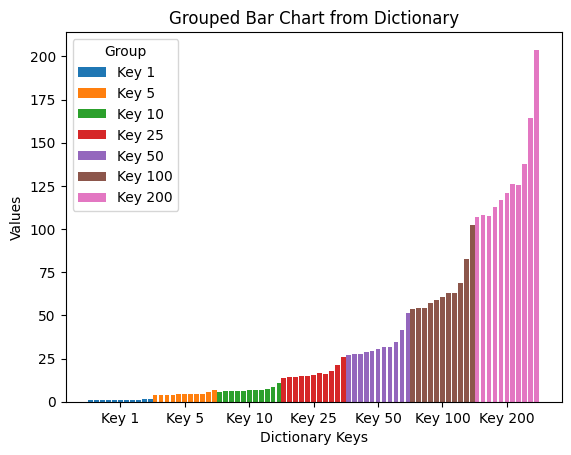

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
data = loaded_data


num_bars = len(next(iter(data.values())))  # Get the length of the first item's list

# Settings for the bars
bar_width = 0.2  # width of each bar
spacing = 0.05  # space between bars in the same group
group_width = num_bars * (bar_width + spacing) - spacing  # Width of each group

# Setup plot
fig, ax = plt.subplots()

# Generate the positions for each group and bar
keys = list(data.keys())
num_groups = len(keys)
index = np.arange(num_groups) * group_width  # Group positions

# Plotting each group
for i, (key, values) in enumerate(data.items()):
    # Calculate the position of each bar within the group
    positions = index[i] + np.arange(num_bars) * (bar_width + spacing)
    
    # Create bars for each value
    ax.bar(positions, values, width=bar_width, label=f'Key {key}')

# Label formatting
ax.set_xlabel('Dictionary Keys')
ax.set_ylabel('Values')
ax.set_title('Grouped Bar Chart from Dictionary')
ax.set_xticks(index + group_width / 2 - bar_width / 2)
ax.set_xticklabels([f'Key {k}' for k in keys])
ax.legend(title='Group')

# Show plot
plt.show()

In [36]:
from itertools import islice

data_first = dict(islice(data.items(), 3))
data_second = dict(islice(data.items(), 3, None))

print(data_first)
print(data_second)

{'1': [1.0914698451990261, 1.1292548101162538, 1.1155320405028761, 1.131549441209063, 1.174847371596843, 1.1879828330362217, 1.227995287301019, 1.1973614852875472, 1.2610144363483413, 1.434437211882323, 1.5827852194663137], '5': [3.8788893463090064, 3.9877998244250192, 3.9765993277775125, 4.0979559548664835, 4.192085879528895, 4.246008853497915, 4.406392005970702, 4.426460397383198, 4.754660756094381, 5.556675424939021, 6.804334148718044], '10': [5.7985726275946945, 5.986119540291838, 5.9607309476938095, 6.238670528959483, 6.3908603668445725, 6.634566395287402, 6.904413482826203, 6.862304451898671, 7.430227790167555, 8.808147239265963, 10.767414055787958]}
{'25': [13.867491051182151, 14.053481059800834, 14.033897646097467, 14.62781998848077, 15.096365386992693, 15.690638205083086, 16.350672146026046, 16.310652193939312, 17.657449743314647, 21.105889725964516, 26.029590523336083], '50': [26.93930550152436, 27.540982268215156, 27.368975999695248, 28.80906267890241, 29.627216527657584, 30

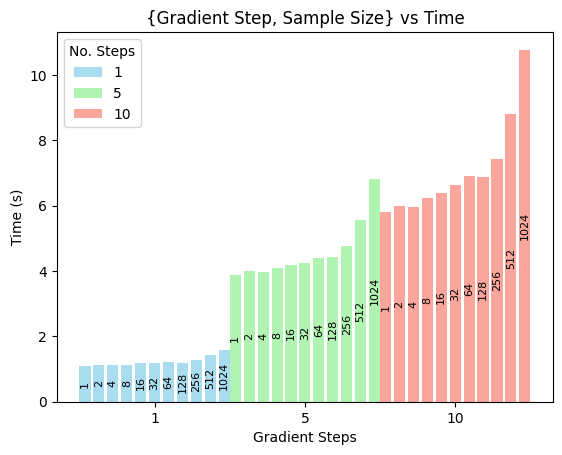

In [85]:
num_bars = len(next(iter(data_first.values())))

# Settings for the bars
bar_width = 0.2  # width of each bar
spacing = 0.05  # space between bars in the same group
group_width = num_bars * (bar_width + spacing) - spacing  # Width of each group

# Setup plot
fig, ax = plt.subplots()

# Generate the positions for each group and bar
keys = list(data_first.keys())
num_groups = len(keys)
index = np.arange(num_groups) * group_width  # Group positions

# Define a list of colors for aesthetic appearance
colors = ['skyblue', 'lightgreen', 'salmon', 'orange', 'purple', 'grey']

# Plotting each group
for i, (key, values) in enumerate(data_first.items()):
    # Calculate the position of each bar within the group
    positions = index[i] + np.arange(num_bars) * (bar_width + spacing)
    
    # Create bars for each value with color and transparency
    bars = ax.bar(positions, values, width=bar_width, color=colors[i % len(colors)], alpha=0.7, label=f'{key}')

    # Label each individual bar
    for bar, size in zip(bars, sample_sizes[:num_bars]):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2,
                str(size), ha='center', va='center', color='black', rotation='vertical', fontsize=8)

# Label formatting
ax.set_xlabel('Gradient Steps')
ax.set_ylabel('Time (s)')
ax.set_title('{Gradient Step, Sample Size} vs Time')
ax.set_xticks(index + group_width / 2 - bar_width / 2)
ax.set_xticklabels([f'{k}' for k in keys])
ax.legend(title='No. Steps')
plt.savefig(f"./Execution_times/grad_steps_sample_size_1.png")

# Show plot
plt.show()


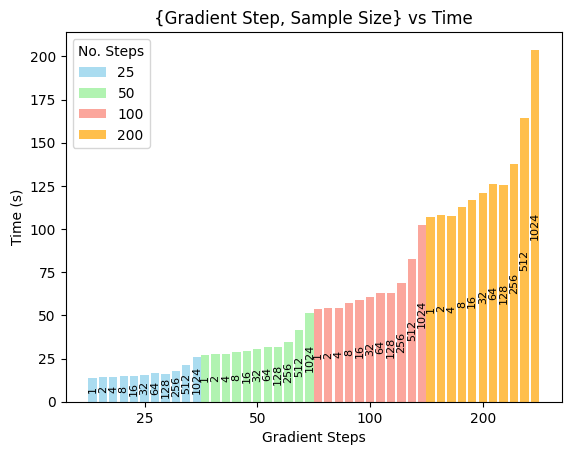

In [86]:
num_bars = len(next(iter(data_second.values())))

# Settings for the bars
bar_width = 0.2  # width of each bar
spacing = 0.05  # space between bars in the same group
group_width = num_bars * (bar_width + spacing) - spacing  # Width of each group

# Setup plot
fig, ax = plt.subplots()

# Generate the positions for each group and bar
keys = list(data_second.keys())
num_groups = len(keys)
index = np.arange(num_groups) * group_width  # Group positions

# Define a list of colors for aesthetic appearance
colors = ['skyblue', 'lightgreen', 'salmon', 'orange', 'purple', 'grey']

# Plotting each group
for i, (key, values) in enumerate(data_second.items()):
    # Calculate the position of each bar within the group
    positions = index[i] + np.arange(num_bars) * (bar_width + spacing)
    
    # Create bars for each value with color and transparency
    bars = ax.bar(positions, values, width=bar_width, color=colors[i % len(colors)], alpha=0.7, label=f'{key}')

    # Label each individual bar
    for bar, size in zip(bars, sample_sizes[:num_bars]):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2,
                str(size), ha='center', va='center', color='black', rotation='vertical', fontsize=8)

# Label formatting
ax.set_xlabel('Gradient Steps')
ax.set_ylabel('Time (s)')
ax.set_title('{Gradient Step, Sample Size} vs Time')
ax.set_xticks(index + group_width / 2 - bar_width / 2)
ax.set_xticklabels([f'{k}' for k in keys])
ax.legend(title='No. Steps')
plt.savefig(f"./Execution_times/grad_steps_sample_size_2.png")


# Show plot
plt.show()